In [1]:
import os
import sys
import time 
import pickle
import subprocess

import numpy as np
import pandas as pd

import mxnet as mx
from mxnet import gluon, autograd

import warnings
warnings.filterwarnings("ignore")

#### Check machine setups

In [2]:
def get_gpu_name():
    try:
        out_str = subprocess.run(["nvidia-smi", "--query-gpu=gpu_name", "--format=csv"], stdout=subprocess.PIPE).stdout
        out_list = out_str.decode("utf-8").split('\n')
        out_list = out_list[1:-1]
        return out_list
    except Exception as e:
        print(e)

In [3]:
GPU_TYPES = get_gpu_name()
GPU_COUNT = len(GPU_TYPES)

In [4]:
print("MXNet: ", mx.__version__)
print("GPU: ", GPU_TYPES)
print("Num GPUs: ", GPU_COUNT)

MXNet:  1.2.1
GPU:  ['GeForce GTX 1080 Ti', 'GeForce GTX TITAN X', 'GeForce GTX 1080 Ti']
Num GPUs:  3


In [5]:
!nvidia-smi

Wed Nov 27 13:56:39 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:17:00.0  On |                  N/A |
| 23%   31C    P8     9W / 250W |   1012MiB / 11175MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX TIT...  Off  | 00000000:65:00.0 Off |                  N/A |
| 22%   37C    P8    14W / 250W |    545MiB / 12212MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

#### load data

In [7]:
# Load pickled data

train_data_file = './data/precessed_train_data.pkl'
train_label_file  = './data/precessed_train_label.pkl'
test_data_file  = './data/precessed_test_data.pkl'
test_label_file  = './data/precessed_test_label.pkl'

with open(train_data_file, mode='rb') as f:
    X_train = pickle.load(f)
with open(train_label_file, mode='rb') as f:
    y_train = pickle.load(f)
with open(test_data_file, mode='rb') as f:
    X_test = pickle.load(f)
with open(test_label_file, mode='rb') as f:
    y_test = pickle.load(f)

In [8]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 86430
Number of testing examples = 12630
Image data shape = (1, 32, 32)
Number of classes = 43


In [9]:
from sklearn.model_selection import train_test_split
XX_train, XX_valid, yy_train, yy_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=815)

print("number of training samples: {}".format(XX_train.shape[0]))
print("number of validation samples: {}".format(XX_valid.shape[0]))
print("number of test samples: {}".format(X_test.shape[0]))

number of training samples: 69144
number of validation samples: 17286
number of test samples: 12630


#### model
Simple LeNet used here only for demo

In [10]:
# # cnn calculator
# W = 32
# F = 3
# S = 1
# p = 0

# ((W-F+2*p)/S) + 1

In [11]:
def tsc_LeNet(x, params):
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x10.
    h1_conv = mx.nd.Convolution(data=x, weight=params[0], bias=params[1], kernel=(5,5), num_filter=10)
    h1_activation = mx.nd.relu(h1_conv)
    # pooling. Input = 28x28x10. Output = 14x14x10.
    h1 = mx.nd.Pooling(data=h1_activation, pool_type="max", kernel=(2,2), stride=(2,2))
    # Layer 2: Convolutional. Input = 14x14x10. Output = 10x10x20.
    h2_conv = mx.nd.Convolution(data=h1, weight=params[2], bias=params[3], kernel=(5,5), num_filter=20)
    h2_activation = mx.nd.relu(h2_conv)
    # Pooling. Input = 10x10x20. Output = 5x5x20.
    h2 = mx.nd.Pooling(data=h2_activation, pool_type="max", kernel=(2,2), stride=(2,2))
    # Flatten. Input = 5x5x20. Output = 500.
    h2 = mx.nd.flatten(h2)
    # Layer 3: Fully Connected. Input = 500. Output = 200.
    h3_linear = mx.nd.dot(h2, params[4]) + params[5]
    h3 = mx.nd.relu(h3_linear)
    # Layer 4: Fully Connected. Input = 200. Output = 120.
    h4_linear = mx.nd.dot(h3, params[6]) + params[7]
    h4 = mx.nd.relu(h4_linear)
    # Layer 5: Fully Connected. Input = 120. Output = 43.
    yhat = mx.nd.dot(h4, params[8]) + params[9]
        
    return yhat

In [12]:
def weight_initialize(std=0.1):
    # initialize parameters
    scale = std
    W1 = mx.nd.random_normal(shape=(10,1,5,5))*scale
    b1 = mx.nd.zeros(shape=10)
    W2 = mx.nd.random_normal(shape=(20,10,5,5))*scale
    b2 = mx.nd.zeros(shape=20)
    W3 = mx.nd.random_normal(shape=(500,200))*scale
    b3 = mx.nd.zeros(shape=200)
    W4 = mx.nd.random_normal(shape=(200,120))*scale
    b4 = mx.nd.zeros(shape=120)
    W5 = mx.nd.random_normal(shape=(120,43))*scale
    b5 = mx.nd.zeros(shape=43)
    params = [W1, b1, W2, b2, W3, b3, W4, b4, W5, b5]
    return params

In [14]:
# def tsc_LeNet():
#     net = gluon.nn.Sequential()
#     with net.name_scope():
#         # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x10.
#         net.add(gluon.nn.Conv2D(channels=10, kernel_size=5, activation='relu'))
#         # pooling. Input = 28x28x10. Output = 14x14x10.
#         net.add(gluon.nn.MaxPool2D(pool_size=(2,2), strides=(2,2)))
#         # Layer 2: Convolutional. Input = 14x14x10. Output = 10x10x20.
#         net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
#         # Pooling. Input = 10x10x20. Output = 5x5x20.
#         net.add(gluon.nn.MaxPool2D(pool_size=(2,2), strides=(2,2)))
#         # Flatten. Input = 5x5x20. Output = 500.
#         net.add(gluon.nn.Flatten())
#         # Layer 3: Fully Connected. Input = 500. Output = 200.
#         net.add(gluon.nn.Dense(200, activation="relu"))
#         # Layer 4: Fully Connected. Input = 200. Output = 120.
#         net.add(gluon.nn.Dense(120, activation="relu"))
#         # Layer 5: Fully Connected. Input = 120. Output = 43.
#         net.add(gluon.nn.Dense(43))
#     return net

In [15]:
# print(tsc_LeNet())

#### train

In [16]:
def SGD(params, lr):
    for p in params:
        p[:] = p - lr * p.grad

In [17]:
def get_params(params, ctx):
    new_params = [p.copyto(ctx) for p in params]
    for p in new_params:
        p.attach_grad()
    return new_params

In [18]:
def allreduce(data):
    # gradients sumup at gpu0
    for i in range(1, len(data)):
        data[0][:] += data[i].copyto(data[0].context)
    # gradients copyto at gpu1, gpu2
    for i in range(1, len(data)):
        data[0].copyto(data[i]) 

In [66]:
def train(num_gpus=1, batch_size=128, epochs=50, lr=0.001):
    
    train_hist = {}
    train_hist['Time_used_epoch'] = []
    train_hist['valid_acc'] = []
    
    # num gpu running
    ctx = [mx.gpu(i) for i in range(num_gpus)]
    print('Training with {} GPUs, Batch size: {}'.format(num_gpus, batch_size))
    print('traing samples: {}, valid samples: {}'.format(XX_train.shape[0], XX_valid.shape[0]))
    
    # Dataloader
    x_train = mx.io.NDArrayIter(XX_train, yy_train, batch_size)
    x_valid = mx.io.NDArrayIter(XX_valid, yy_valid, batch_size)
    
    SCE_loss = gluon.loss.SoftmaxCrossEntropyLoss()
    # initialize the weights 
    params = weight_initialize(std=0.1)
    # publish the weights to gpus
    devices_params = [get_params(params, g) for g in ctx]
    
    # main loop
    for epoch in range(epochs):
        
        start_t = time.time()
        # startover the samples iterations
        x_train.reset()
        
        for batch in x_train:
            
            # parallel the data, feed into the gpus
            # xx, yy is the list with the length according to operationg gpus, len(batch_size)/len(ctx)
            xx = gluon.utils.split_and_load(batch.data[0], ctx)
            yy = gluon.utils.split_and_load(batch.label[0], ctx)
            
            # calculate gradients
            with autograd.record():
                loss_collections = [SCE_loss(tsc_LeNet(xx_gpu, ww_gpu), yy_gpu) 
                                    for xx_gpu, yy_gpu, ww_gpu in zip(xx, yy, devices_params)]
            for l in loss_collections:
                l.backward()
                
            for i in range(len(devices_params[0])):
                allreduce([devices_params[c][i].grad for c in range(len(ctx))])
                
            # update weights on each GPU
            for p in devices_params:
                SGD(p, lr/batch.data[0].shape[0])
                
        # time guard since mxnet asynchronously queue operations    
        mx.nd.waitall()
        time_consum = time.time()-start_t
        print('[Epoch %d, Time used = %.2f sec]' % (epoch, time_consum))
        
        train_hist['Time_used_epoch'].append(time_consum)
        
        # validating
        x_valid.reset()
        correct, num = 0.0, 0.0
        
        for batch in x_valid:
            infer_gpu = 0
            
            valid_data = batch.data[0].as_in_context(ctx[infer_gpu])
            pred = mx.nd.argmax(tsc_LeNet(valid_data, devices_params[infer_gpu]), axis=1)
            pred_res = mx.nd.sum(pred == batch.label[0].as_in_context(ctx[infer_gpu])).asscalar()
            correct += pred_res
            num += batch.data[0].shape[0]
        
        valid_acc = correct/num
        print('validation accuracy = %.4f'%(valid_acc))
        train_hist['valid_acc'].append(valid_acc)
        
    with open('./model/mxnet_ts_weights_{}_{}.pkl'.format(num_gpus, batch_size),'wb') as f:
        pickle.dump(devices_params, f)
        
    return train_hist

In [72]:
batchsize_test = [96, 128, 192, 256, 320]

In [73]:
g1_evaluation_hist =[]
g2_evaluation_hist =[]
g3_evaluation_hist =[]
for i in range(len(batchsize_test)):
    g1_lr = 0.005
    g1_hist = train(num_gpus=1, batch_size=batchsize_test[i], epochs=50, lr=g1_lr)
    g2_hist = train(num_gpus=2, batch_size=batchsize_test[i]*2, epochs=50, lr=g1_lr*2)
    g3_hist = train(num_gpus=3, batch_size=batchsize_test[i]*3, epochs=50, lr=g1_lr*3)
    
    g1_evaluation_hist.append(g1_hist)
    g2_evaluation_hist.append(g2_hist)
    g3_evaluation_hist.append(g3_hist)
    
with open('./eval_matrix/g1_evaluation_hist.pkl','wb') as f:
    pickle.dump(g1_evaluation_hist, f)
with open('./eval_matrix/g2_evaluation_hist.pkl','wb') as f:
    pickle.dump(g2_evaluation_hist, f)
with open('./eval_matrix/g3_evaluation_hist.pkl','wb') as f:
    pickle.dump(g3_evaluation_hist, f)

Training with 1 GPUs, Batch size: 96
traing samples: 69144, valid samples: 17286
[Epoch 0, Time used = 1.36 sec]
validation accuracy = 0.2935
[Epoch 1, Time used = 1.29 sec]
validation accuracy = 0.5058
[Epoch 2, Time used = 1.39 sec]
validation accuracy = 0.6149
[Epoch 3, Time used = 1.33 sec]
validation accuracy = 0.6754
[Epoch 4, Time used = 1.34 sec]
validation accuracy = 0.7188
[Epoch 5, Time used = 1.43 sec]
validation accuracy = 0.7456
[Epoch 6, Time used = 1.34 sec]
validation accuracy = 0.7684
[Epoch 7, Time used = 1.28 sec]
validation accuracy = 0.7880
[Epoch 8, Time used = 1.36 sec]
validation accuracy = 0.8039
[Epoch 9, Time used = 1.40 sec]
validation accuracy = 0.8179
[Epoch 10, Time used = 1.33 sec]
validation accuracy = 0.8284
[Epoch 11, Time used = 1.30 sec]
validation accuracy = 0.8394
[Epoch 12, Time used = 1.36 sec]
validation accuracy = 0.8471
[Epoch 13, Time used = 1.28 sec]
validation accuracy = 0.8545
[Epoch 14, Time used = 1.43 sec]
validation accuracy = 0.8614

[Epoch 29, Time used = 1.55 sec]
validation accuracy = 0.8804
[Epoch 30, Time used = 1.54 sec]
validation accuracy = 0.8824
[Epoch 31, Time used = 1.50 sec]
validation accuracy = 0.8837
[Epoch 32, Time used = 1.53 sec]
validation accuracy = 0.8850
[Epoch 33, Time used = 1.65 sec]
validation accuracy = 0.8892
[Epoch 34, Time used = 1.59 sec]
validation accuracy = 0.8923
[Epoch 35, Time used = 1.56 sec]
validation accuracy = 0.8973
[Epoch 36, Time used = 1.54 sec]
validation accuracy = 0.8999
[Epoch 37, Time used = 1.55 sec]
validation accuracy = 0.9029
[Epoch 38, Time used = 1.59 sec]
validation accuracy = 0.9053
[Epoch 39, Time used = 1.54 sec]
validation accuracy = 0.9085
[Epoch 40, Time used = 1.49 sec]
validation accuracy = 0.9101
[Epoch 41, Time used = 1.50 sec]
validation accuracy = 0.9121
[Epoch 42, Time used = 1.49 sec]
validation accuracy = 0.9136
[Epoch 43, Time used = 1.50 sec]
validation accuracy = 0.9144
[Epoch 44, Time used = 1.48 sec]
validation accuracy = 0.9152
[Epoch 4

[Epoch 8, Time used = 1.13 sec]
validation accuracy = 0.7550
[Epoch 9, Time used = 1.15 sec]
validation accuracy = 0.7691
[Epoch 10, Time used = 1.13 sec]
validation accuracy = 0.7828
[Epoch 11, Time used = 1.24 sec]
validation accuracy = 0.7952
[Epoch 12, Time used = 1.12 sec]
validation accuracy = 0.8057
[Epoch 13, Time used = 1.11 sec]
validation accuracy = 0.8165
[Epoch 14, Time used = 1.13 sec]
validation accuracy = 0.8247
[Epoch 15, Time used = 1.11 sec]
validation accuracy = 0.8313
[Epoch 16, Time used = 1.11 sec]
validation accuracy = 0.8377
[Epoch 17, Time used = 1.12 sec]
validation accuracy = 0.8431
[Epoch 18, Time used = 1.16 sec]
validation accuracy = 0.8477
[Epoch 19, Time used = 1.18 sec]
validation accuracy = 0.8525
[Epoch 20, Time used = 1.12 sec]
validation accuracy = 0.8573
[Epoch 21, Time used = 1.18 sec]
validation accuracy = 0.8616
[Epoch 22, Time used = 1.15 sec]
validation accuracy = 0.8668
[Epoch 23, Time used = 1.21 sec]
validation accuracy = 0.8704
[Epoch 24,

[Epoch 38, Time used = 0.74 sec]
validation accuracy = 0.8757
[Epoch 39, Time used = 0.74 sec]
validation accuracy = 0.8787
[Epoch 40, Time used = 0.74 sec]
validation accuracy = 0.8806
[Epoch 41, Time used = 0.74 sec]
validation accuracy = 0.8811
[Epoch 42, Time used = 0.74 sec]
validation accuracy = 0.8833
[Epoch 43, Time used = 0.74 sec]
validation accuracy = 0.8851
[Epoch 44, Time used = 0.74 sec]
validation accuracy = 0.8871
[Epoch 45, Time used = 0.74 sec]
validation accuracy = 0.8884
[Epoch 46, Time used = 0.74 sec]
validation accuracy = 0.8903
[Epoch 47, Time used = 0.74 sec]
validation accuracy = 0.8916
[Epoch 48, Time used = 0.74 sec]
validation accuracy = 0.8931
[Epoch 49, Time used = 0.76 sec]
validation accuracy = 0.8941
Training with 3 GPUs, Batch size: 576
traing samples: 69144, valid samples: 17286
[Epoch 0, Time used = 0.78 sec]
validation accuracy = 0.1510
[Epoch 1, Time used = 0.76 sec]
validation accuracy = 0.3095
[Epoch 2, Time used = 0.78 sec]
validation accuracy 

[Epoch 17, Time used = 0.57 sec]
validation accuracy = 0.7690
[Epoch 18, Time used = 0.59 sec]
validation accuracy = 0.7775
[Epoch 19, Time used = 0.57 sec]
validation accuracy = 0.7846
[Epoch 20, Time used = 0.58 sec]
validation accuracy = 0.7912
[Epoch 21, Time used = 0.56 sec]
validation accuracy = 0.7971
[Epoch 22, Time used = 0.56 sec]
validation accuracy = 0.8033
[Epoch 23, Time used = 0.56 sec]
validation accuracy = 0.8091
[Epoch 24, Time used = 0.56 sec]
validation accuracy = 0.8138
[Epoch 25, Time used = 0.58 sec]
validation accuracy = 0.8183
[Epoch 26, Time used = 0.57 sec]
validation accuracy = 0.8227
[Epoch 27, Time used = 0.57 sec]
validation accuracy = 0.8274
[Epoch 28, Time used = 0.57 sec]
validation accuracy = 0.8314
[Epoch 29, Time used = 0.58 sec]
validation accuracy = 0.8354
[Epoch 30, Time used = 0.56 sec]
validation accuracy = 0.8391
[Epoch 31, Time used = 0.56 sec]
validation accuracy = 0.8423
[Epoch 32, Time used = 0.57 sec]
validation accuracy = 0.8451
[Epoch 3

[Epoch 47, Time used = 0.85 sec]
validation accuracy = 0.8487
[Epoch 48, Time used = 0.84 sec]
validation accuracy = 0.8515
[Epoch 49, Time used = 0.84 sec]
validation accuracy = 0.8534
Training with 2 GPUs, Batch size: 640
traing samples: 69144, valid samples: 17286
[Epoch 0, Time used = 0.51 sec]
validation accuracy = 0.1085
[Epoch 1, Time used = 0.51 sec]
validation accuracy = 0.2095
[Epoch 2, Time used = 0.51 sec]
validation accuracy = 0.3059
[Epoch 3, Time used = 0.49 sec]
validation accuracy = 0.3770
[Epoch 4, Time used = 0.49 sec]
validation accuracy = 0.4310
[Epoch 5, Time used = 0.48 sec]
validation accuracy = 0.4784
[Epoch 6, Time used = 0.49 sec]
validation accuracy = 0.5162
[Epoch 7, Time used = 0.49 sec]
validation accuracy = 0.5475
[Epoch 8, Time used = 0.49 sec]
validation accuracy = 0.5733
[Epoch 9, Time used = 0.52 sec]
validation accuracy = 0.6000
[Epoch 10, Time used = 0.49 sec]
validation accuracy = 0.6229
[Epoch 11, Time used = 0.49 sec]
validation accuracy = 0.640

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

In [76]:
for eg1 in g1_evaluation_hist:
    aa = eg1['Time_used_epoch']
    break

In [104]:
g1_time = np.array([np.mean(eg1['Time_used_epoch']) for eg1 in g1_evaluation_hist])
g2_time = np.array([np.mean(eg2['Time_used_epoch']) for eg2 in g2_evaluation_hist])
g3_time = np.array([np.mean(eg3['Time_used_epoch']) for eg3 in g3_evaluation_hist])
g1_acc = np.array([np.max(eg1['valid_acc']) for eg1 in g1_evaluation_hist])
g2_acc = np.array([np.max(eg2['valid_acc']) for eg2 in g2_evaluation_hist])
g3_acc = np.array([np.max(eg3['valid_acc']) for eg3 in g3_evaluation_hist])

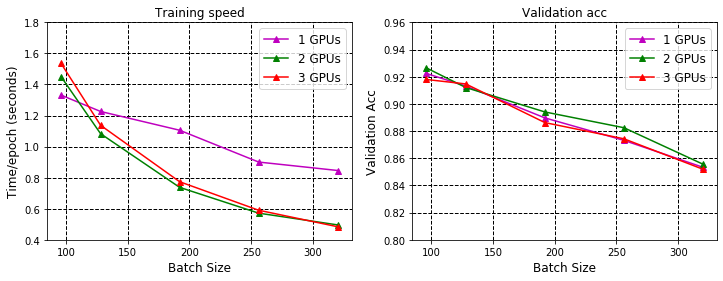

In [132]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].plot(batchsize_test, g1_time,'-^', c='m', label='1 GPUs')
ax[0].plot(batchsize_test, g2_time,'-^', c='g', label='2 GPUs')
ax[0].plot(batchsize_test, g3_time,'-^', c='r', label='3 GPUs')

ax[1].plot(batchsize_test, g1_acc,'-^', c='m', label='1 GPUs')
ax[1].plot(batchsize_test, g2_acc,'-^', c='g', label='2 GPUs')
ax[1].plot(batchsize_test, g3_acc,'-^', c='r', label='3 GPUs')

ax[0].set_ylim(0.4,1.8)
ax[0].set_ylabel('Time/epoch (seconds)', fontsize=12)
ax[0].set_xlabel('Batch Size', fontsize=12)
ax[0].set_title('Training speed', fontsize=12)
# ax[0].set_xticks(np.arange(0,0.9,0.05))
# ax[0].set_xticklabels(np.arange(0, 95, 5))
# ax[0].set_xlim(0,1)

ax[1].set_ylim(0.8,0.96)
ax[1].set_ylabel('Validation Acc', fontsize=12)
ax[1].set_xlabel('Batch Size', fontsize=12)
ax[1].set_title('Validation acc', fontsize=12)

ax[0].grid(color='k', linestyle='--', linewidth=1.0)
ax[0].legend(loc='upper right', fontsize=12)
ax[1].grid(color='k', linestyle='--', linewidth=1.0)
ax[1].legend(loc='upper right', fontsize=12)

plt.show()
fig.savefig('eval_matrix/evaluation_Mean.png', bbox_inches = 'tight')